# Video Classification Using Transfer Learning | UCF101 - Action Recognition

In [ ]:
# pip install imageio tqdm opencv-python tensorflow

## Import Packages

In [1]:
import glob # glob is a Python module used for file pattern matching, allowing you to retrieve file paths that match a specified pattern (e.g., *.txt)
import pandas as pd
import cv2 # cv2 is a Python library that provides functions for image processing and computer vision tasks, such as reading, writing, and manipulating images, as well as performing tasks like object detection and feature extraction.
import gc # gc is a Python module that provides functions to interact with the garbage collection process, allowing manual control over memory management, such as forcing garbage collection or disabling it. It helps optimize memory usage and clean up unused objects.
import numpy as np
import random
import imageio # imageio is a Python library used for reading and writing image data, supporting a wide range of image formats and providing easy interfaces for handling images, videos, and volumes.
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image  # display images and other rich media in Jupyter notebooks or IPython environments.display is used to render objects in the output cell. Image is used to display an image from a file or URL.

# Configuration

In [2]:
# Configuration
epochs = 10
batch_size = 32
classes = ["ApplyEyeMakeup", "ApplyLipstick", "Archery"]

# Data Loading and Preprocessing

In [3]:
# Simple frame formatting function
def format_frames(frame, output_size=(224, 224)):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

# Read and process video frames
def frames_from_video_file(video_path, n_frames=10, output_size=(224,224), frame_step=15):
    result = []
    src = cv2.VideoCapture(video_path)
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    start = random.randint(0, max(0, video_length - 1 - (n_frames - 1) * frame_step))
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))
        for _ in range(n_frames - 1):
            for _ in range(frame_step):
                src.read()
            ret, frame = src.read()
            if ret:
                result.append(format_frames(frame, output_size))
            else:
                result.append(np.zeros_like(result[0]))
    src.release()
    return np.array(result)[..., [2, 1, 0]]  # BGR to RGB

# Load and process the dataset
file_paths, targets = [], []
for i, cls in enumerate(classes):
    file_paths.extend(glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi"))
    targets.extend([i] * len(glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")))


# Visualization

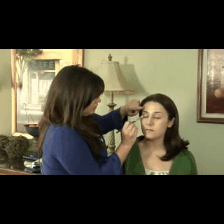

In [4]:
# Convert frames to GIF for visualization
def to_gif(images):
    images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', images, fps=10)
    display(Image(filename='./animation.gif'))
    
# Visualize sample video
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
to_gif(sample_video)

# Train Test Split

In [5]:
# Prepare training and validation datasets
features = [frames_from_video_file(f, n_frames=10) for f in tqdm(file_paths)]
features = np.array(features)
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)) \
    .shuffle(batch_size * 4).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)) \
    .batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

del features  # Cleanup
gc.collect()

  0%|          | 0/404 [00:00<?, ?it/s]

18

# Training Transformer Learning Model (EffiecientNet Family)

In [11]:
import tensorflow as tf

# Define and compile the model
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define Callbacks outside training
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')


# Train the model
history = efficient_net_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]
)


Epoch 1/10


2025-02-07 08:14:58.879280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/time_distributed_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11/11 [==============================] - 16s 625ms/step - loss: 0.9066 - accuracy: 0.5480 - val_loss: 0.6123 - val_accuracy: 0.8765
Epoch 2/10
11/11 [==============================] - 4s 401ms/step - loss: 0.5177 - accuracy: 0.8514 - val_loss: 0.4090 - val_accuracy: 0.9383
Epoch 3/10
11/11 [==============================] - 4s 402ms/step - loss: 0.3646 - accuracy: 0.9381 - val_loss: 0.3097 - val_accuracy: 0.9753
Epoch 4/10
11/11 [==============================] - 4s 403ms/step - loss: 0.2830 - accuracy: 0.9659 - val_loss: 0.2459 - val_accuracy: 0.9753
Epoch 5/10
11/11 [==============================] - 4s 402ms/step - loss: 0.2285 - accuracy: 0.9752 - val_loss: 0.2062 - val_accuracy: 0.9877
Epoch 6/10
11/11 [==============================] - 4s 402ms/step - loss: 0.1989 - accuracy: 0.9783 - val_loss: 0.1785 - val_accuracy: 0.9877
Epoch 7/10
11/11 [==============================] - 4s 402ms/step - loss: 0.1693 - accuracy: 0.9845 - val_loss: 0.1566 - val_accuracy: 0.9877
Epoch 8/10
11/11

# Model Evaluation

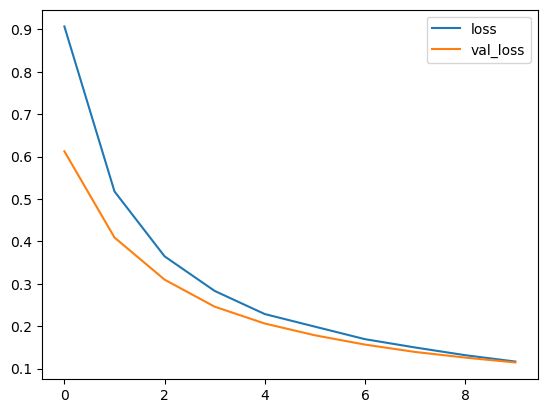

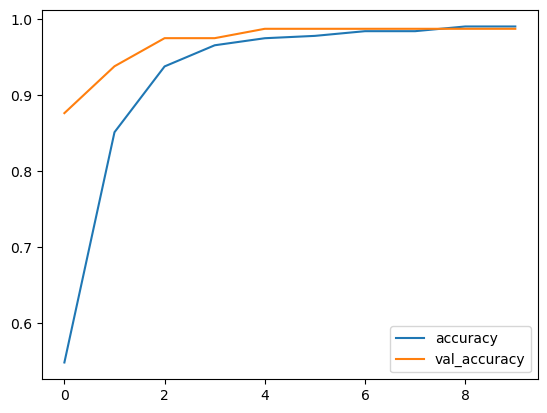

In [16]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show

In [17]:
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

3/3 [==============================] - 1s 266ms/step - loss: 0.1144 - accuracy: 0.9877
Validation Loss:0.11438282579183578 Validation Accuracy:0.9876543283462524


# Real Time Detection System

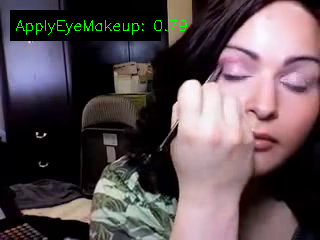

Processing complete! Output saved as 'output.avi'.


In [18]:
import cv2
import numpy as np
import tensorflow as tf
import time
from IPython.display import display, clear_output

def detect_video(video_path, model, class_names, n_frames=10, output_size=(224, 224), frame_step=15):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Define video writer for output (optional)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while cap.isOpened():
        frames = []
        for _ in range(n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, output_size)
            frame_resized = frame_resized / 255.0  # Normalize
            frames.append(frame_resized)

        if len(frames) < n_frames:
            break  # Stop if not enough frames

        frames = np.array(frames)
        frames = np.expand_dims(frames, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(frames)
        class_idx = np.argmax(predictions)
        confidence = np.max(tf.nn.softmax(predictions))

        # Read frame again for display
        ret, frame = cap.read()
        if not ret:
            break
        
        # Draw a black rectangle for the label
        cv2.rectangle(frame, (10, 10), (160, 40), (0, 0, 0), -1)  # Background box
        
        # Draw prediction text in the top-left corner (smaller font)
        text = f"{class_names[class_idx]}: {confidence:.2f}"
        cv2.putText(frame, text, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Write to output file
        out.write(frame)

        # Display frame in Jupyter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_frame(frame_rgb)

        # Add small delay for smooth playback
        time.sleep(0.03)

    cap.release()
    out.release()
    print("Processing complete! Output saved as 'output.avi'.")

def display_frame(frame_rgb):
    """ Helper function to display video frames inline in Jupyter Notebook """
    clear_output(wait=True)
    from IPython.display import display
    import PIL.Image
    img = PIL.Image.fromarray(frame_rgb)
    display(img)

# Example usage
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi", efficient_net_model, classes)


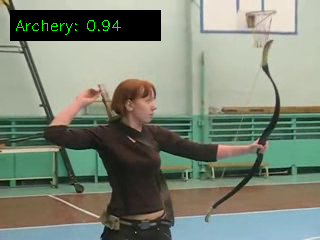

Processing complete! Output saved as 'output.avi'.


In [19]:
# Example usage
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/Archery/v_Archery_g01_c04.avi", efficient_net_model, classes)

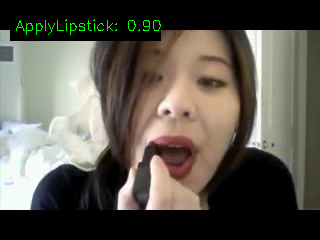

Processing complete! Output saved as 'output.avi'.


In [20]:
# Example usage
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/ApplyLipstick/v_ApplyLipstick_g01_c04.avi", efficient_net_model, classes)